In [251]:
!pip install pulp
from pulp import *
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sys

In [0]:
#!{sys.executable} -m pip install xlrd

# Importing the dataset

In [253]:
df = pd.read_excel("openfoodfacts_simplified_database.xlsx")
df = df[~df['nutrition_grade_fr'].isna()]
df['nutrition_grade_fr'].describe()

count     5925
unique       5
top          d
freq      1599
Name: nutrition_grade_fr, dtype: object

In [254]:
cols = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'nutrition_grade_fr']
df = df[cols]
df.columns = ['energy', 'saturated_fat', 'sugars', 'fiber', 'proteins', 'salt', 'nutriscore']
df.head()

,energy,saturated_fat,sugars,fiber,proteins,salt,nutriscore
0,590.0,0.5,5.5,1.8,6.2,0.236,b
3,1477.0,1.5,10.0,9.9,5.4,2.200,b
4,176.0,0.0,9.7,0.0,0.5,0.000,c
8,1022.0,1.9,0.5,1.4,12.0,0.332,b
9,196.0,0.0,11.0,0.5,0.7,0.040,c


In [0]:
df = df[~df['energy'].isna()]
df = df[~df['saturated_fat'].isna()]
df = df[~df['sugars'].isna()]
df = df[~df['fiber'].isna()]
df = df[~df['proteins'].isna()]
df = df[~df['salt'].isna()]

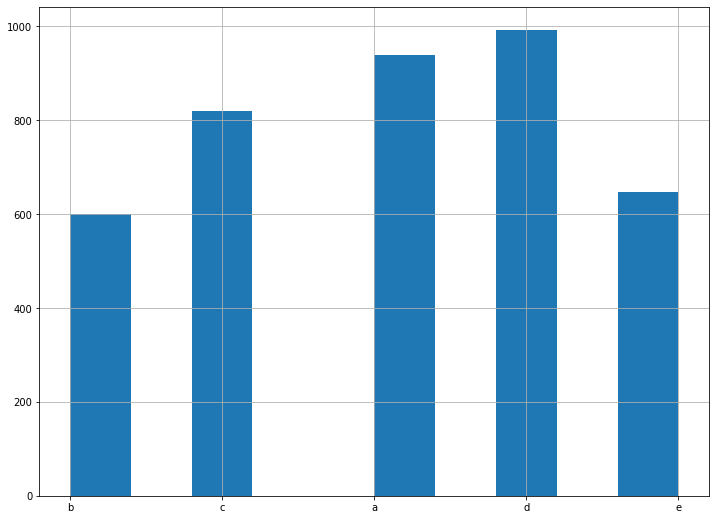

In [256]:
df['nutriscore'].hist()

In [0]:
def create_buckets(df, criterion, precision, eps):
    num_buckets = int((df[criterion].max() + eps - df[criterion].min()) / precision)
    max_value = df[criterion].max() + eps
    min_value = df[criterion].min()
    real_precision = (max_value - min_value) / num_buckets
    
    buckets = []
    left_thresh = min_value
    for i in range(num_buckets):
        buckets.append((left_thresh, left_thresh+real_precision))
        left_thresh = left_thresh+real_precision

    return buckets

In [0]:
buckets = {}

37


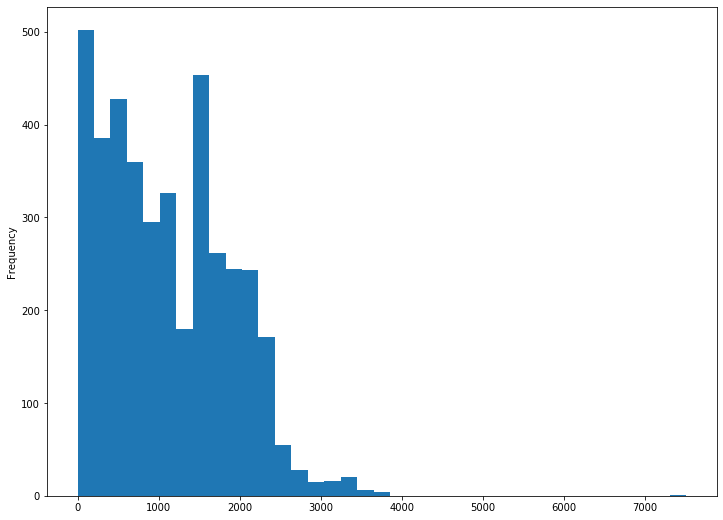

In [259]:
bins = int((df['energy'].max() - df['energy'].min()) / 200)
print(bins)
df['energy'].plot.hist(bins=bins)

50


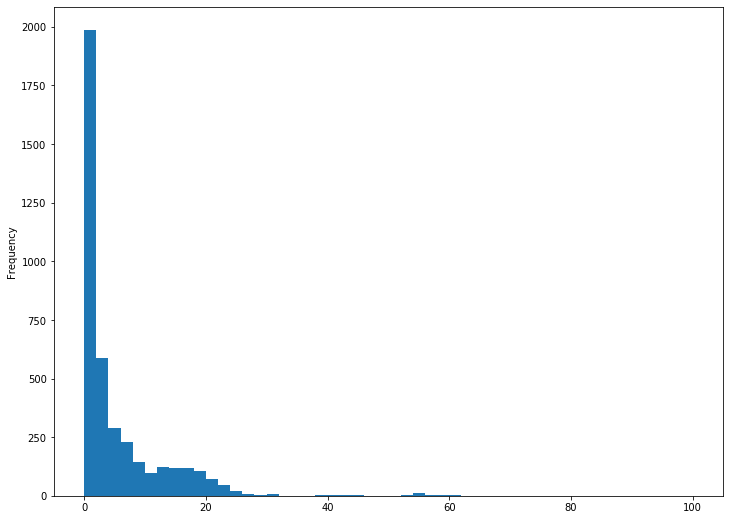

In [260]:
bins = int((df['saturated_fat'].max() - df['saturated_fat'].min()) / 2)
print(bins)
df['saturated_fat'].plot.hist(bins=bins)

25


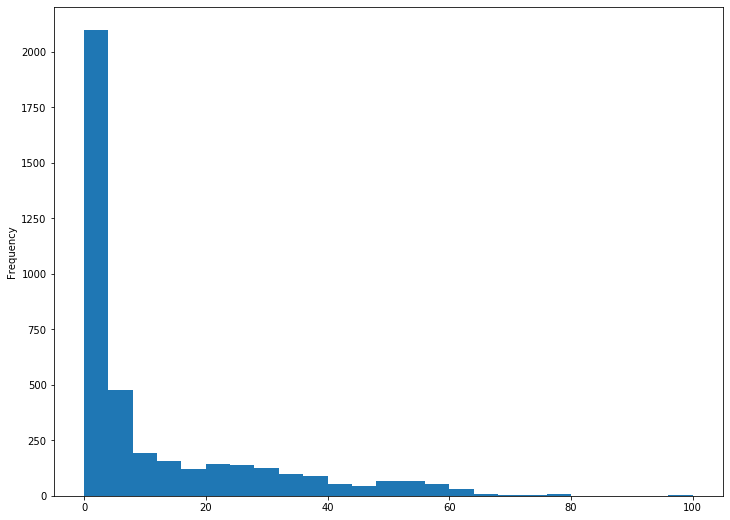

In [261]:
bins = int((df['sugars'].max() - df['sugars'].min()) / 4)
print(bins)
df['sugars'].plot.hist(bins=bins)

68


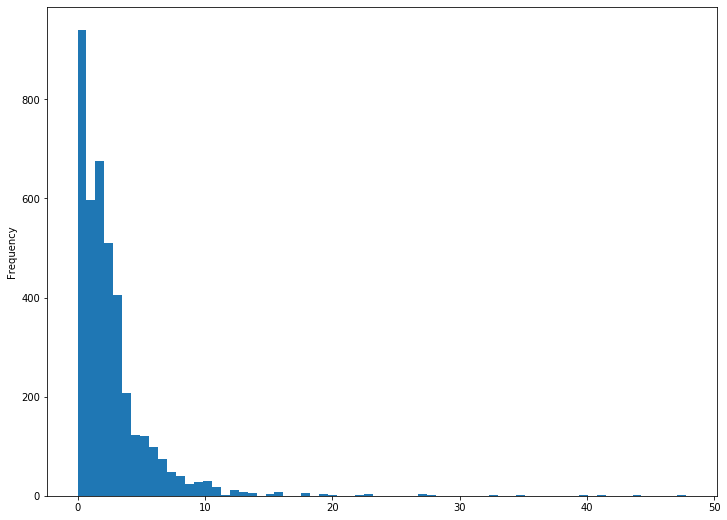

In [262]:
bins = int((df['fiber'].max() - df['fiber'].min()) / 0.7)
print(bins)
df['fiber'].plot.hist(bins=bins)

20


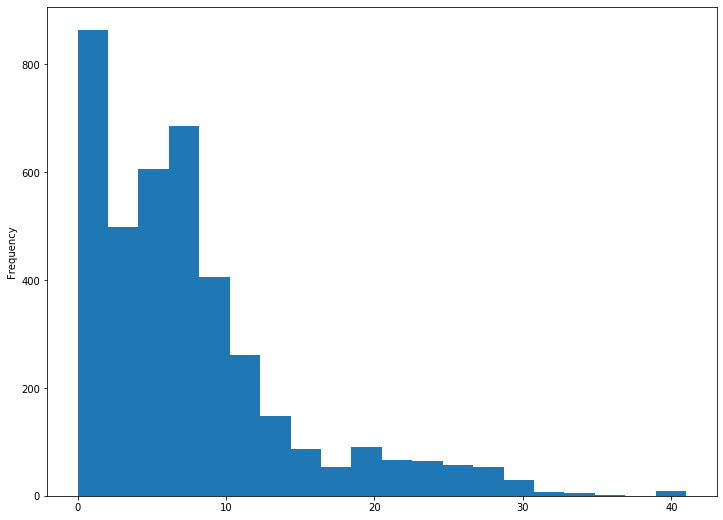

In [263]:
bins = int((df['proteins'].max() - df['proteins'].min()) / 2)
print(bins)
df['proteins'].plot.hist(bins=bins)

97


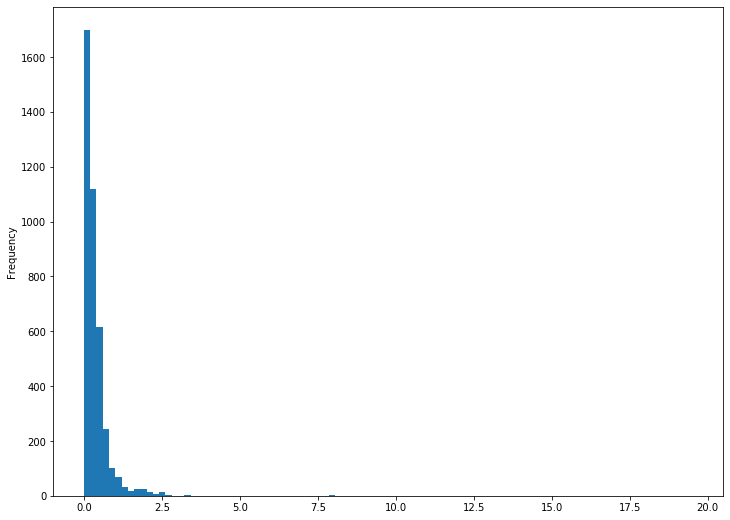

In [264]:
bins = int((df['salt'].max() - df['salt'].min()) / 0.2)
print(bins)
df['salt'].plot.hist(bins=bins)

# Create the buckets

In [0]:
buckets['energy'] = create_buckets(df, 'energy', precision=200, eps=10)
buckets['saturated_fat'] = create_buckets(df, 'saturated_fat', precision=2, eps=0.1)
buckets['sugars'] = create_buckets(df, 'sugars', precision=4, eps=0.1)
buckets['fiber'] = create_buckets(df, 'fiber', precision=0.7, eps=0.1)
buckets['proteins'] = create_buckets(df, 'proteins', precision=2, eps=0.1)
buckets['salt'] = create_buckets(df, 'salt', precision=0.2, eps=0.05)

# Split the dataset

In [0]:
features = ['energy', 'proteins', 'salt', 'fiber', 'saturated_fat', 'sugars']
X = df[features]
y = df[['nutriscore']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

In [268]:
df = X_train
df['nutriscore'] = y_train['nutriscore']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [269]:
df.count()[0]

799

In [270]:
df_test = X_test
df_test['nutriscore'] = y_test['nutriscore']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [271]:
df_test.count()[0]

3196

# Formalize the problem

In [0]:
prob = LpProblem("Nutriscore", LpMinimize)

In [0]:
sigma = {}

for index, food in df.iterrows():
  sigma[index] = LpVariable("sigma_"+str(index),0, sys.maxsize)

In [0]:
# The objective function is added to 'prob' first
prob += lpSum(list(sigma.values())), "Error in the ranking to be minimized"

In [0]:
utility_thresh = {}
for key in buckets:
    utility_thresh[key] = []
    
for key in buckets:    
    for i in range(len(buckets[key])):
        utility_thresh[key].append(LpVariable(key+"_"+str(i), 0, 1))
    utility_thresh[key].append(LpVariable(key+"_"+str(len(buckets[key])), 0, 1))

In [0]:
def get_bucket_index(value, buckets):
    return get_bucket_index_r(value, buckets, 0, len(buckets)-1)

In [0]:
def get_bucket_index_r(value, buckets, left, right):
    middle = int((right - left) / 2 + left)
    if (value >= buckets[middle][0]) and (value < buckets[middle][1]):
        return middle
    if value < buckets[middle][0]:
        return get_bucket_index_r(value, buckets, left, middle-1)
    return get_bucket_index_r(value, buckets, middle+1, right)

In [0]:
def utility_func(df, food_index):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket_index(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [279]:
df['nutriscore'] = np.where(df['nutriscore']=='a', 5, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='b', 4, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='c', 3, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='d', 2, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='e', 1, df['nutriscore'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [280]:
df.head()

,energy,proteins,salt,fiber,saturated_fat,sugars,nutriscore
781,1035.0,29.00,1.800,0.00,5.90,0.50,2
4140,724.0,4.90,0.308,1.00,5.30,1.70,3
2829,301.0,0.87,0.408,0.84,0.85,4.45,5
2719,114.0,2.00,0.340,1.50,0.00,1.50,5
1150,1506.0,30.00,0.000,19.00,1.60,3.10,5


In [0]:
for index, food in df.iterrows():
    utility_food = utility_func(df, index)
    preceding_foods = df[df['nutriscore'] == food['nutriscore']-1]
    for index2, preceding_food in preceding_foods.iterrows():
        utility_prec_food = utility_func(preceding_foods, index2)
        prob += (utility_food + sigma[index] >= utility_prec_food + sigma[index2] + 0.001)

In [0]:
prob += utility_thresh['energy'][len(utility_thresh['energy'])-1] == 0
prob += utility_thresh['saturated_fat'][len(utility_thresh['saturated_fat'])-1] == 0
prob += utility_thresh['sugars'][len(utility_thresh['sugars'])-1] == 0
prob += utility_thresh['salt'][len(utility_thresh['salt'])-1] == 0
prob += utility_thresh['proteins'][0] == 0
prob += utility_thresh['fiber'][0] == 0

In [0]:
prob += utility_thresh['energy'][0] + \
        utility_thresh['saturated_fat'][0] + \
        utility_thresh['sugars'][0] + \
        utility_thresh['salt'][0] + \
        utility_thresh['proteins'][len(utility_thresh['proteins'])-1] + \
        utility_thresh['fiber'][len(utility_thresh['fiber'])-1] == 1

In [0]:
for i in range(len(utility_thresh['energy'])-1):
    prob += utility_thresh['energy'][i] >= utility_thresh['energy'][i+1]
for i in range(len(utility_thresh['saturated_fat'])-1):
    prob += utility_thresh['saturated_fat'][i] >= utility_thresh['saturated_fat'][i+1]
for i in range(len(utility_thresh['sugars'])-1):
    prob += utility_thresh['sugars'][i] >= utility_thresh['sugars'][i+1]
for i in range(len(utility_thresh['salt'])-1):
    prob += utility_thresh['salt'][i] >= utility_thresh['salt'][i+1]

for i in range(len(utility_thresh['proteins'])-1):
    prob += utility_thresh['proteins'][i] <= utility_thresh['proteins'][i+1]
for i in range(len(utility_thresh['fiber'])-1):
    prob += utility_thresh['fiber'][i] <= utility_thresh['fiber'][i+1]

In [285]:
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [286]:
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)

energy_0 = 0.0011581212
energy_1 = 0.00115751
energy_10 = 0.00059682597
energy_11 = 0.0
energy_12 = 0.0
energy_13 = 0.0
energy_14 = 0.0
energy_15 = 0.0
energy_16 = 0.0
energy_17 = 0.0
energy_18 = 0.0
energy_19 = 0.0
energy_2 = 0.00115751
energy_20 = 0.0
energy_21 = 0.0
energy_22 = 0.0
energy_23 = 0.0
energy_24 = 0.0
energy_25 = 0.0
energy_26 = 0.0
energy_27 = 0.0
energy_28 = 0.0
energy_29 = 0.0
energy_3 = 0.00115751
energy_30 = 0.0
energy_31 = 0.0
energy_32 = 0.0
energy_33 = 0.0
energy_34 = 0.0
energy_35 = 0.0
energy_36 = 0.0
energy_37 = 0.0
energy_4 = 0.00115751
energy_5 = 0.00115751
energy_6 = 0.001100233
energy_7 = 0.0010377394
energy_8 = 0.0010377394
energy_9 = 0.00074131284
fiber_0 = 0.0
fiber_1 = 4.7652871e-06
fiber_10 = 0.0013873184
fiber_11 = 0.0014042236
fiber_12 = 0.0015719669
fiber_13 = 0.0015719669
fiber_14 = 0.0015719669
fiber_15 = 0.0015719669
fiber_16 = 0.0015719669
fiber_17 = 0.0015719669
fiber_18 = 0.0015719669
fiber_19 = 0.0015719669
fiber_2 = 1.7726623e-05
fiber_20 =

# Plotting Utility functions

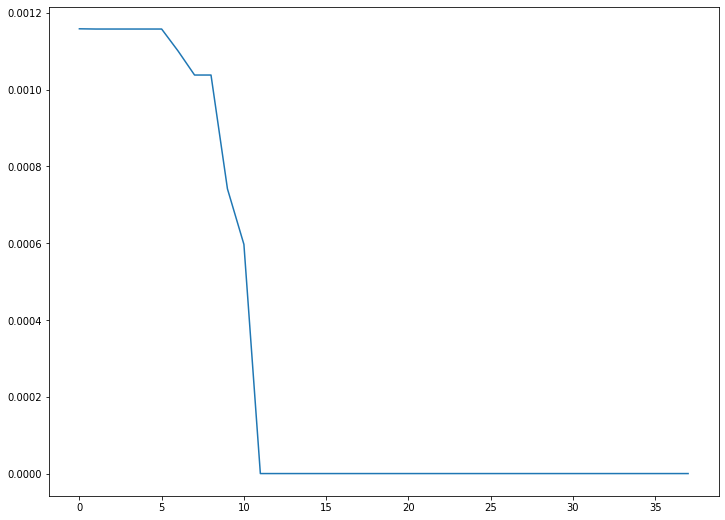

In [287]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([e.value() for e in utility_thresh['energy']])
plt.savefig('thresh_energy.jpg')

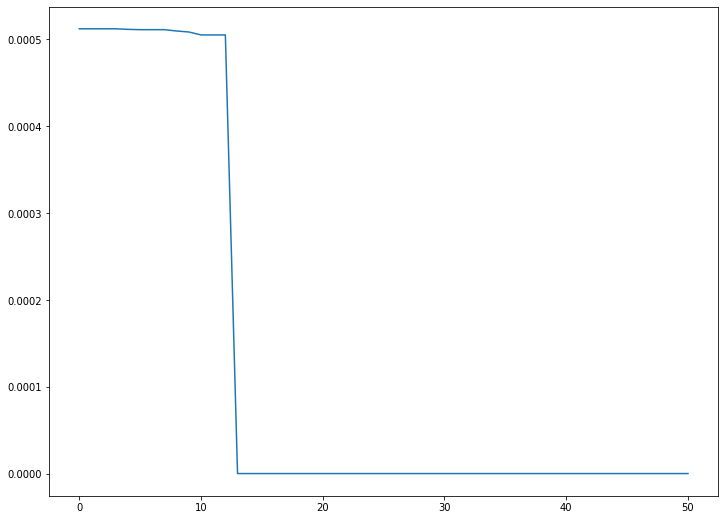

In [288]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([sf.value() for sf in utility_thresh['saturated_fat']])
plt.savefig('thresh_saturated_fat.jpg')

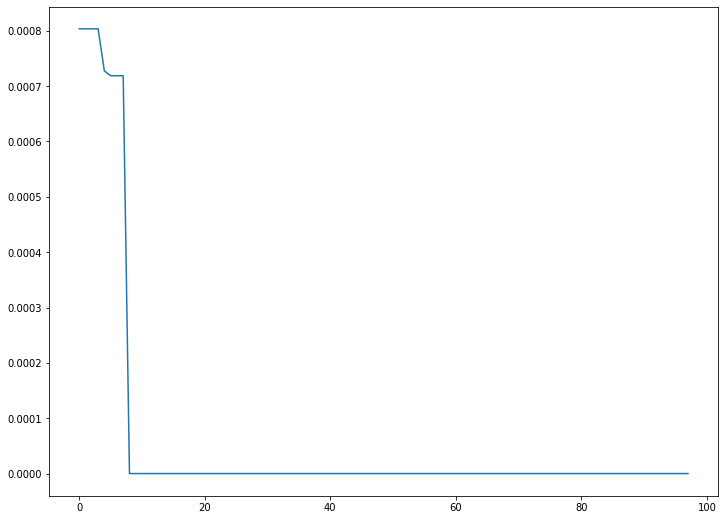

In [289]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([s.value() for s in utility_thresh['salt']])
plt.savefig('thresh_salt.jpg')

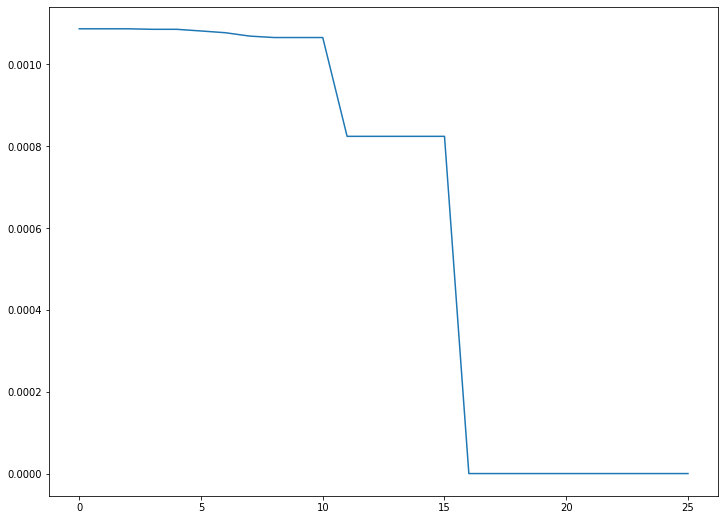

In [290]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([su.value() for su in utility_thresh['sugars']])
plt.savefig('thresh_sugars.jpg')

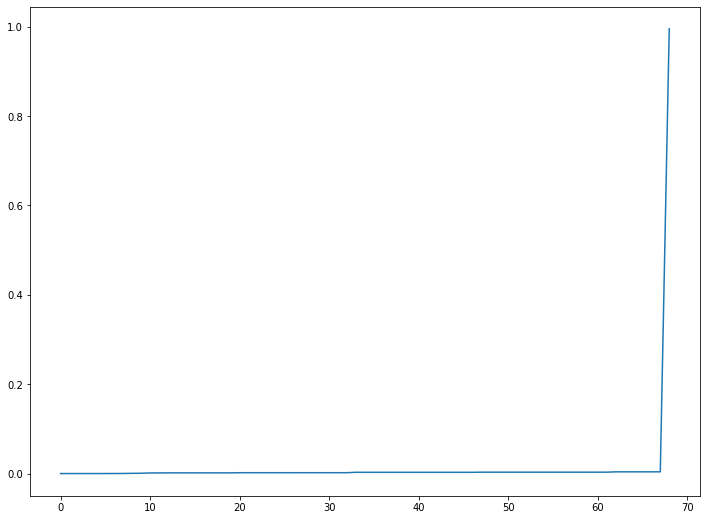

In [291]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([f.value() for f in utility_thresh['fiber']])
plt.savefig('thresh_fiber.jpg')

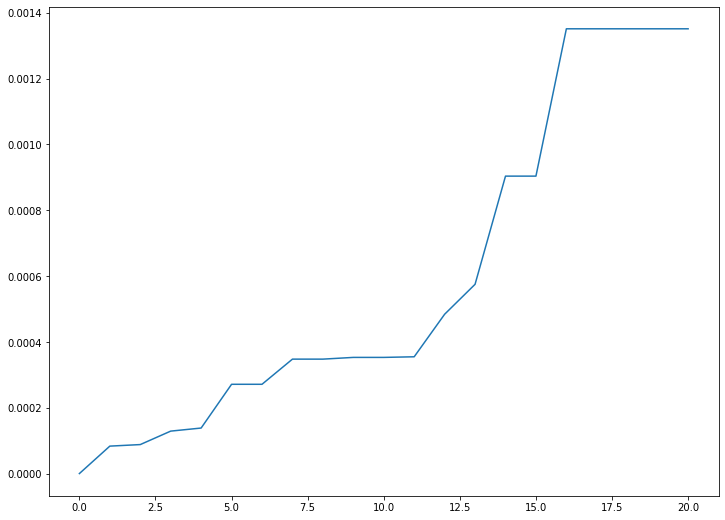

In [292]:
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([p.value() for p in utility_thresh['proteins']])
plt.savefig('thresh_proteins.jpg')

# Testing


In [0]:
def utility_func_prod(df, food_index, utility_thresh):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket_index(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [0]:
df_test = df_test.sample(100)

In [0]:
food_scores = []
for index, food in df_test.iterrows():
  pred = utility_func_prod(df_test, index, utility_thresh_prod)
  nutriscore = food['nutriscore']
  food_scores.append({'pred': pred, 'nutriscore': nutriscore})

In [0]:
food_scores.sort(key=lambda food: food['pred'], reverse=True)

In [297]:
food_scores

[{'nutriscore': 'd', 'pred': 0.01456027309500289},
 {'nutriscore': 'd', 'pred': 0.008700240783768206},
 {'nutriscore': 'c', 'pred': 0.006003783646956228},
 {'nutriscore': 'b', 'pred': 0.005126675767774709},
 {'nutriscore': 'a', 'pred': 0.005103200598713137},
 {'nutriscore': 'b', 'pred': 0.00485572154030363},
 {'nutriscore': 'b', 'pred': 0.0047241940560079024},
 {'nutriscore': 'a', 'pred': 0.0046808303281924216},
 {'nutriscore': 'a', 'pred': 0.004634388151190018},
 {'nutriscore': 'd', 'pred': 0.004598417858825149},
 {'nutriscore': 'd', 'pred': 0.00454950482616854},
 {'nutriscore': 'b', 'pred': 0.00448111889296546},
 {'nutriscore': 'b', 'pred': 0.004465629298750006},
 {'nutriscore': 'c', 'pred': 0.004412112056113334},
 {'nutriscore': 'd', 'pred': 0.004290863667321672},
 {'nutriscore': 'c', 'pred': 0.004122774313996901},
 {'nutriscore': 'd', 'pred': 0.004081968164404793},
 {'nutriscore': 'e', 'pred': 0.004042938053688255},
 {'nutriscore': 'a', 'pred': 0.004020444899323145},
 {'nutriscore'